In [4]:
import numpy as np
from numpy.linalg import inv
from numpy.random import multivariate_normal, uniform, seed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs, make_biclusters 
from sklearn.metrics import silhouette_samples, silhouette_score
from jupyterthemes import jtplot 
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, 
             gridlines='--', ticks=True, grid=False, figsize=(7, 5))
import warnings
from time import sleep
from IPython import display
from scipy.spatial.distance import cdist
%matplotlib notebook
warnings.filterwarnings('ignore')
seed(42)

In [5]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)  
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)  
plt.rc('ytick', labelsize=SMALL_SIZE)

### 2D Cluster Demo

In [6]:
def sample_clusters(n_points=500, n_dimensions=2, 
                    n_clusters=5, cluster_std=1):
    data, labels = make_blobs(n_samples=n_points, 
                               n_features=n_dimensions, 
                               centers=n_clusters, 
                               cluster_std=cluster_std, 
                               random_state=42)
    return data, labels

### Evaluate Number of Clusters

In [7]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='white', lw=1, title='Inertia', ax=ax, xlim=(inertias.index[0], inertias.index[-1]), ylim=(0, inertias.max()))
    fig.canvas.draw()
    sleep(delay)

In [8]:
def plot_kmeans_result(data, labels, centroids, 
                       assignments, ncluster, Z, ax):
    ax.scatter(*data.T, c=labels, s=15) # plot data

    # plot cluster centers
    ax.scatter(*centroids.T, marker='o', c='w', 
               s=200, edgecolor='k', zorder=9)
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), 
                   s=50, edgecolor='k', zorder=10)
        xy = pd.DataFrame(data[assignments == i], 
                columns=['x', 'y']).assign(cx=c[0], cy=c[1])
        ax.plot(xy[['x', 'cx']].T, xy[['y', 'cy']].T, 
                ls='--', color='white', lw=0.5)

    # plot voronoi
    ax.imshow(Z, interpolation='nearest', 
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.viridis, aspect='auto', origin='lower', alpha=.2)
    ax.set_title('Number of Clusters: {}'.format(ncluster))
    plt.tight_layout()

### Run Elbow Experiment

<IPython.core.display.Javascript object>


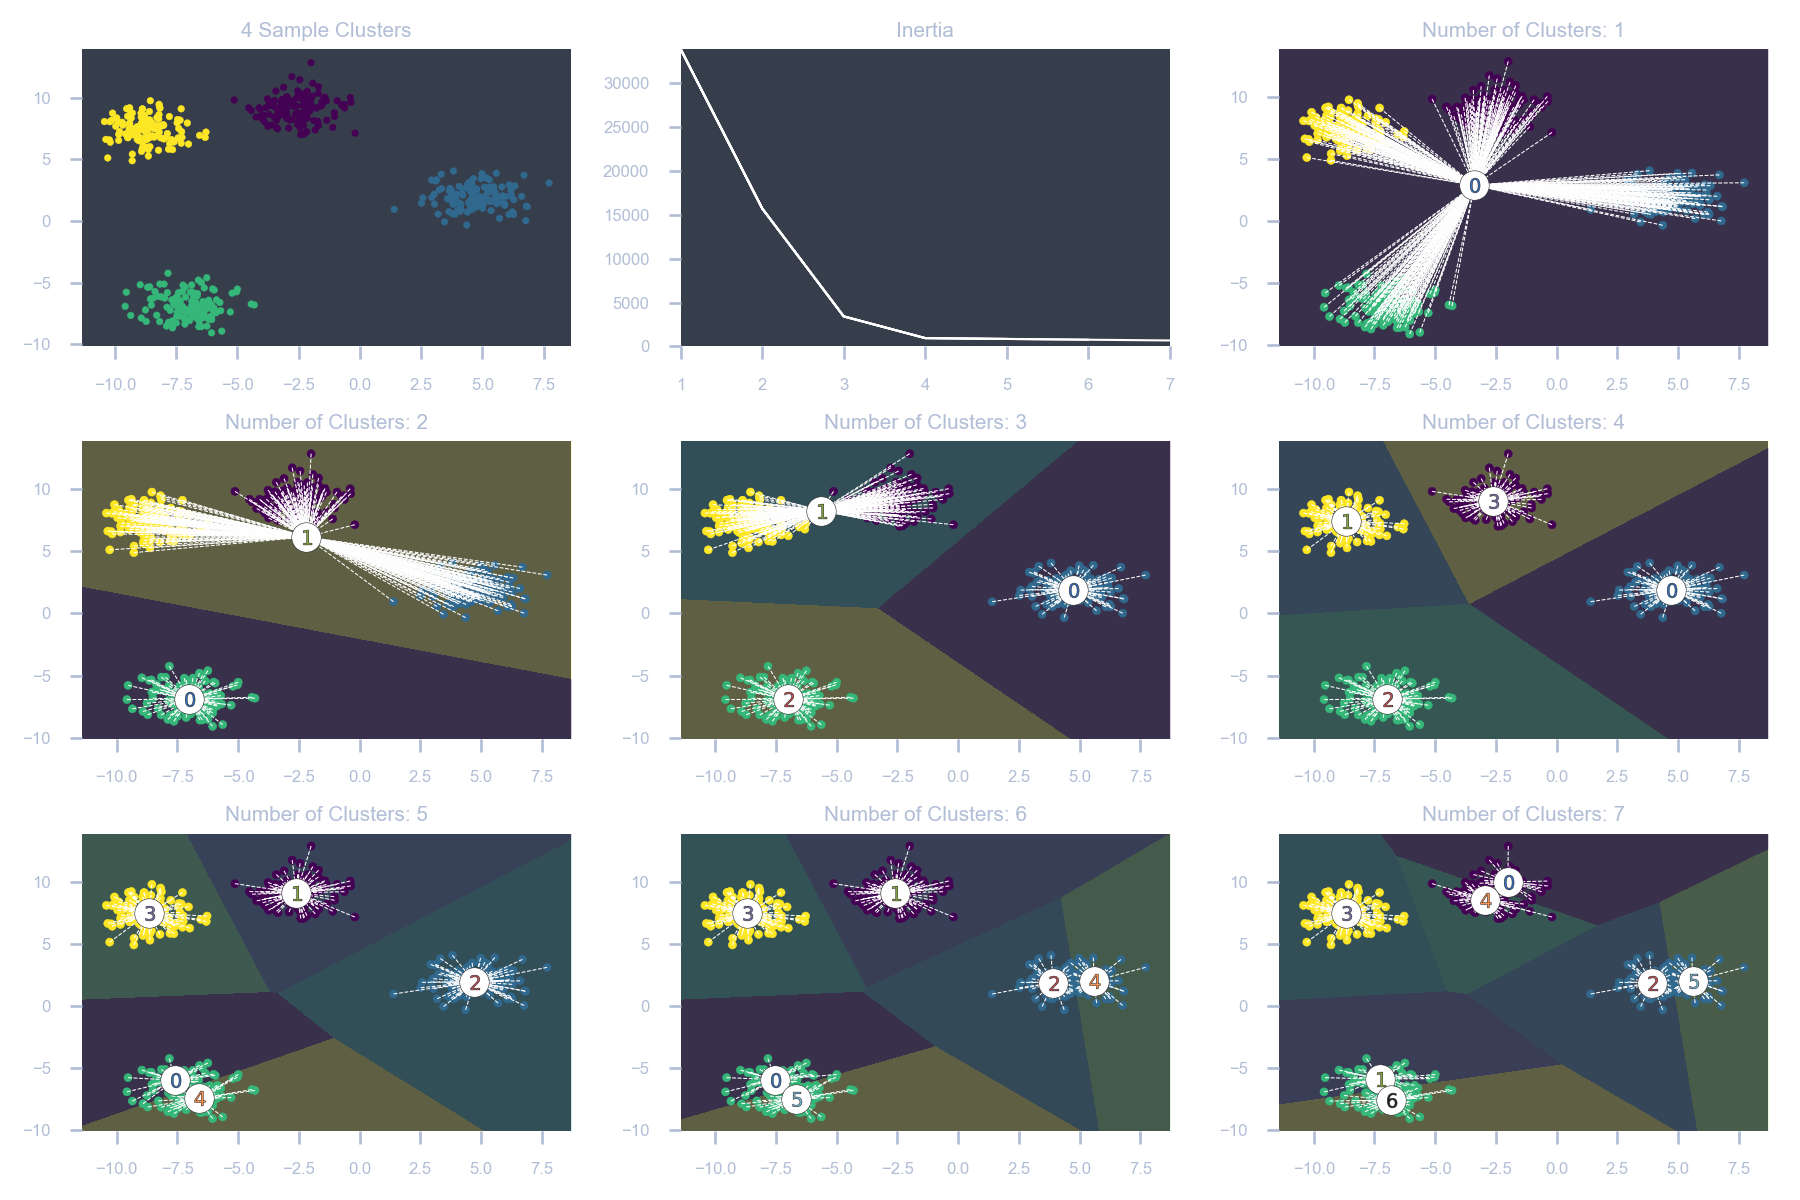

In [19]:
n_clusters = 4
max_clusters = 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

data, labels = sample_clusters(n_clusters=n_clusters)
x, y = data.T

xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01), 
                     np.arange(y.min() - 1, y.max() + 1, .01))
             
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 8))
axes = np.array(axes).flatten()
plt.tight_layout();

# Plot Sample Data
axes[0].scatter(x, y, c=labels, s=10)
axes[0].set_title('{} Sample Clusters'.format(n_clusters));

for c, n_clusters in enumerate(range(1, max_clusters + 1), 2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    centroids, assignments, inertia = \
        kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_clusters] = inertia
    inertia_plot_update(inertias, axes[1])
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plot_kmeans_result(data, labels, centroids, assignments, 
                       n_clusters, Z, axes[c])

### Evaluating the Silhouette Score

In [14]:
def plot_silhouette(values, y_lower, i, n_cluster, ax):
    cluster_size = values.shape[0]
    y_upper = y_lower + cluster_size

    color = plt.cm.viridis(i / n_cluster)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10
    return y_lower

In [15]:
def format_silhouette_plot(ax):
    ax.set_title("Silhouette Plot")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.axvline(
        x=silhouette_avg, color="red", linestyle="--", lw=1)
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [16]:
def plot_final_assignments(x, y, centroids, 
                           assignments, n_cluster, ax):
    c = plt.cm.viridis(assignments / n_cluster)
    ax.scatter(x, y, marker='.', s=30, 
               lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(*centroids.T, marker='o',  
               c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), 
                   s=50, edgecolor='k')

    ax.set_title('{} Clusters'.format(n_cluster))

<IPython.core.display.Javascript object>


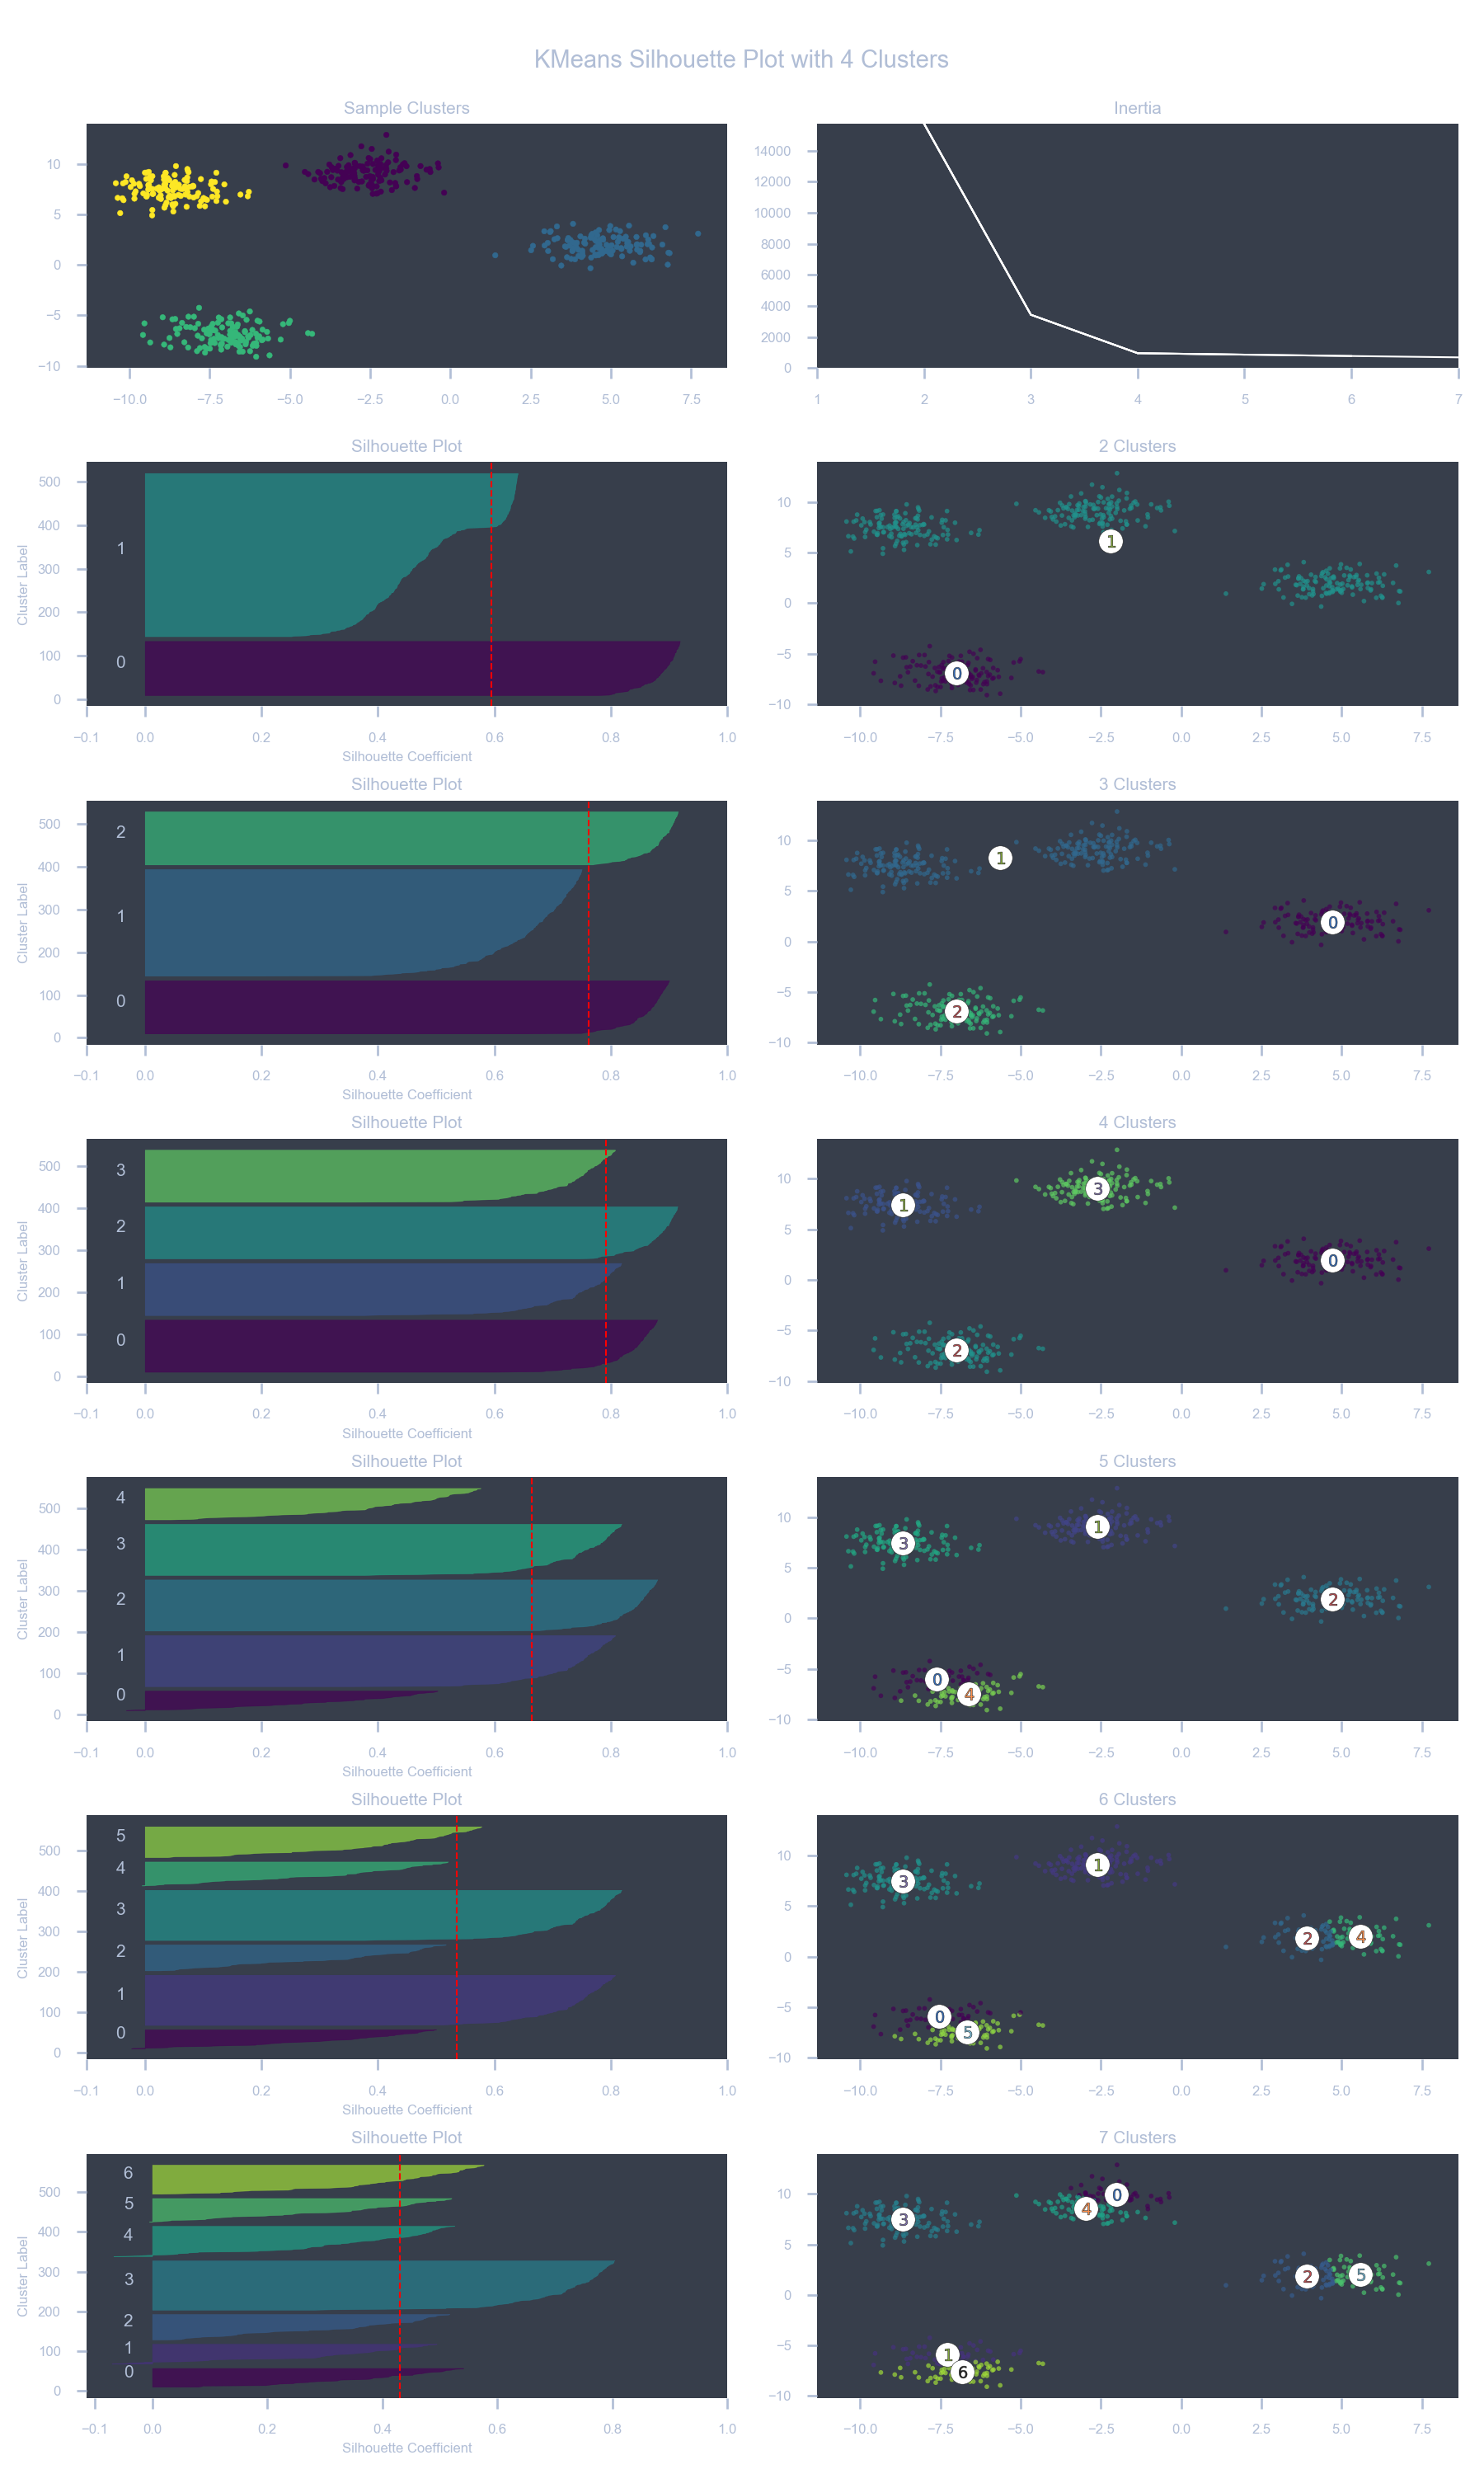

In [17]:
n_clusters = 4
max_clusters = 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

data, labels = sample_clusters(n_clusters=n_clusters)
x, y = data.T

fig, axes = plt.subplots(ncols=2, 
                    nrows=max_clusters, figsize=(12, 20))
fig.tight_layout()
axes[0][0].scatter(x, y, c=labels, s=10)
axes[0][0].set_title('Sample Clusters')

for row, n_cluster in enumerate(range(2, max_clusters + 1), 1):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(data)
    centroids, assignments, inertia = \
        kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[0][1])

    silhouette_avg = silhouette_score(data, assignments)
    silhouette_values = silhouette_samples(data, assignments)
    silhouette_plot, cluster_plot = axes[row]

    y_lower = 10
    for i in range(n_cluster):
        y_lower = plot_silhouette(np.sort(silhouette_values[assignments == i]), y_lower, i, n_cluster, silhouette_plot)
    format_silhouette_plot(silhouette_plot)
    plot_final_assignments(x, y, centroids, assignments, n_cluster, cluster_plot)
    fig.tight_layout()

fig.suptitle('KMeans Silhouette Plot with {} Clusters'.format(n_clusters), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.95)